In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import joblib

In [2]:
# Load pretrained VGG16 model
vgg16_model = load_model(r"C:\Users\K M SASTRY\Desktop\PROJECT\vgg16_model.h5")
vgg16_model = tf.keras.Model(inputs=vgg16_model.input, outputs=vgg16_model.get_layer('flatten').output)
for layer in vgg16_model.layers:
    layer.trainable = False


In [3]:
# Data directories
train_dir = r"K:\PROJECT\ORGANISED DATASET\train"
test_dir = r"K:\PROJECT\ORGANISED DATASET\test"

In [4]:
# Data preprocessing
train_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32, class_mode='binary', shuffle=False)

test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(224, 224), batch_size=32, class_mode='binary', shuffle=False)

Found 6185 images belonging to 2 classes.
Found 1724 images belonging to 2 classes.


In [5]:
# Feature extraction
def extract_features(generator, model):
    features = model.predict(generator, verbose=1)
    labels = generator.classes
    return features, labels

train_features, train_labels = extract_features(train_generator, vgg16_model)
test_features, test_labels = extract_features(test_generator, vgg16_model)

54/54 [==============================] - 973s 18s/step


In [6]:
# Standardization
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)
print(f"Number of features before PCA: {train_features_scaled.shape[1]}")

Number of features before PCA: 25088


In [7]:
# Apply PCA
pca = PCA(n_components=0.95)
train_features_pca = pca.fit_transform(train_features_scaled)
test_features_pca = pca.transform(test_features_scaled)
print(f"Number of features after PCA: {train_features_pca.shape[1]}")

Number of features after PCA: 3354


In [8]:
# Optimized KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=7, weights='distance', metric='minkowski', p=2)
knn_classifier.fit(train_features_pca, train_labels)

KNeighborsClassifier(n_neighbors=7, weights='distance')

In [9]:
# Evaluate KNN classifier
test_predictions = knn_classifier.predict(test_features_pca)
accuracy = accuracy_score(test_labels, test_predictions)
print(f"Test Accuracy with PCA and optimized KNN: {accuracy:.4f}")

Test Accuracy with PCA and optimized KNN: 0.7210


In [10]:
print("Classification Report with PCA:")
print(classification_report(test_labels, test_predictions, target_names=test_generator.class_indices.keys()))

Classification Report with PCA:
              precision    recall  f1-score   support

      BENIGN       0.77      0.16      0.27       542
   MALIGNANT       0.72      0.98      0.83      1182

    accuracy                           0.72      1724
   macro avg       0.74      0.57      0.55      1724
weighted avg       0.73      0.72      0.65      1724



In [11]:
# Save models
vgg16_model.save(r'C:\Users\K M SASTRY\Desktop\CAPSTONE PROJECT\vgg16_with_knn_pca.h5')
joblib.dump(pca, r'C:\Users\K M SASTRY\Desktop\CAPSTONE PROJECT\pca_model.pkl')
joblib.dump(knn_classifier, r'C:\Users\K M SASTRY\Desktop\CAPSTONE PROJECT\knn_classifier_model.pkl')
print("Models saved successfully.")

C:\Users\K M SASTRY\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Models saved successfully.


1/1 [==============================] - 0s 261ms/step


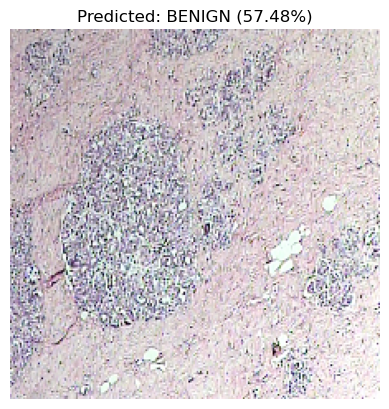

Prediction Probabilities:
BENIGN: 57.48%
MALIGNANT: 42.52%


In [33]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Function for single image prediction
def predict_image(image_path, model, knn_classifier, scaler, pca, class_indices):
    # Load and preprocess image
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Extract features using CNN model
    features = model.predict(img_array)

    # Apply scaling and PCA transformation
    features_scaled = scaler.transform(features)
    features_pca = pca.transform(features_scaled)

    # KNN Prediction
    prediction = knn_classifier.predict(features_pca)[0]  # Get predicted class index
    probabilities = knn_classifier.predict_proba(features_pca)[0]  # Get probability array

    # Ensure only 'BENIGN' and 'MALIGNANT' classes exist
    valid_classes = ["BENIGN", "MALIGNANT"]
    class_labels = {i: class_name for i, class_name in enumerate(valid_classes)}

    # Handle out-of-range predictions
    predicted_class = class_labels.get(prediction, "Unknown")

    # Display image with prediction
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class} ({max(probabilities) * 100:.2f}%)")
    plt.show()

    # Print prediction probabilities (Only BENIGN & MALIGNANT)
    print("Prediction Probabilities:")
    for i, prob in enumerate(probabilities[:2]):  
        print(f"{class_labels[i]}: {prob * 100:.2f}%")

# Example usage
image_path = r"K:\PROJECT\ORGANISED DATASET\test\BENIGN\tubular_adenoma\SOB_B_TA_14-13200\40X\SOB_B_TA-14-13200-40-015.png"
predict_image(image_path, vgg16_model, knn_classifier, scaler, pca, train_generator.class_indices)


1/1 [==============================] - 0s 263ms/step


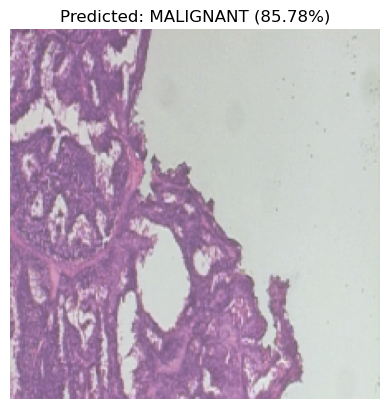

Prediction Probabilities:
BENIGN: 14.22%
MALIGNANT: 85.78%


In [32]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Function for single image prediction
def predict_image(image_path, model, knn_classifier, scaler, pca, class_indices):
    # Load and preprocess image
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Extract features using CNN model
    features = model.predict(img_array)

    # Apply scaling and PCA transformation
    features_scaled = scaler.transform(features)
    features_pca = pca.transform(features_scaled)

    # KNN Prediction
    prediction = knn_classifier.predict(features_pca)[0]  # Get predicted class index
    probabilities = knn_classifier.predict_proba(features_pca)[0]  # Get probability array

    # Ensure only 'BENIGN' and 'MALIGNANT' classes exist
    valid_classes = ["BENIGN", "MALIGNANT"]
    class_labels = {i: class_name for i, class_name in enumerate(valid_classes)}

    # Handle out-of-range predictions
    predicted_class = class_labels.get(prediction, "Unknown")

    # Display image with prediction
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class} ({max(probabilities) * 100:.2f}%)")
    plt.show()

    # Print prediction probabilities (Only BENIGN & MALIGNANT)
    print("Prediction Probabilities:")
    for i, prob in enumerate(probabilities[:2]):  
        print(f"{class_labels[i]}: {prob * 100:.2f}%")

# Example usage
image_path = r"K:\PROJECT\ORGANISED DATASET\test\MALIGNANT\papillary_carcinoma\SOB_M_PC_14-9146\40X\SOB_M_PC-14-9146-40-007.png"
predict_image(image_path, vgg16_model, knn_classifier, scaler, pca, train_generator.class_indices)
